In [35]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

### TCGA

In [26]:
TCGAamp=pd.read_csv("TCGAamp.tsv",sep='\t')
print(TCGAamp.shape)

TCGApatient=pd.read_csv("TCGApatient.tsv",sep='\t')
print(TCGApatient.shape)

(975, 32)
(994, 12)


In [27]:
def classify_amp(row):
    if row['MYC'] and row['PVT1']:
        return 'amp_MYC'
    elif row['PVT1']:
        return 'amp'
    else:
        return False

In [28]:
TCGAamp['MYC'] = TCGAamp['OncogenesAmplified'].str.contains(r'\bMYC\b', na=False)
TCGAamp['PVT1'] = TCGAamp['OncogenesAmplified'].str.contains(r'\bPVT1\b', na=False)

TCGAamp['amp_type'] = TCGAamp.apply(classify_amp, axis=1)

myc_positive_patients = TCGAamp.loc[TCGAamp['MYC'], 'patient_barcode'].unique()
pvt1_positive_patients = TCGAamp.loc[TCGAamp['PVT1'], 'patient_barcode'].unique()

TCGApatient['MYC'] = TCGApatient['patient_barcode'].isin(myc_positive_patients)
TCGApatient['PVT1'] = TCGApatient['patient_barcode'].isin(pvt1_positive_patients)

priority = {'amp_MYC': 2, 'amp': 1, False: 0}
TCGAamp['amp_priority'] = TCGAamp['amp_type'].map(priority)

top_amp_type = TCGAamp.sort_values('amp_priority', ascending=False) \
                      .drop_duplicates(subset='patient_barcode', keep='first') \
                      [['patient_barcode', 'amp_type']]
TCGApatient_updated = TCGApatient.merge(top_amp_type, on='patient_barcode', how='left')
TCGApatient_updated['amp_type'] = TCGApatient_updated['amp_type'].fillna(False)

TCGApatient_updated['FocalAmp'].value_counts()

Negative    639
Positive    355
Name: FocalAmp, dtype: int64

In [29]:
crc_projects_tcga = ['COAD', 'READ']
tcga_crc = TCGApatient_updated[TCGApatient_updated['project'].isin(crc_projects_tcga)]
tcga_crc.shape

(12, 15)

### PCAWGS

In [30]:
PCAWGamp=pd.read_csv("PCAWGamp.tsv",sep='\t')
print(PCAWGamp.shape)

PCAWGpatient=pd.read_csv("PCAWGpatient.tsv",sep='\t')
print(PCAWGpatient.shape)

(2688, 32)
(2645, 12)


In [31]:
PCAWGamp['MYC'] = PCAWGamp['OncogenesAmplified'].str.contains(r'\bMYC\b', na=False)
PCAWGamp['PVT1'] = PCAWGamp['OncogenesAmplified'].str.contains(r'\bPVT1\b', na=False)

PCAWGamp['amp_type'] = PCAWGamp.apply(classify_amp, axis=1)

myc_positive_patients = PCAWGamp.loc[PCAWGamp['MYC'], 'patient_barcode'].unique()
pvt1_positive_patients = PCAWGamp.loc[PCAWGamp['PVT1'], 'patient_barcode'].unique()

PCAWGpatient['MYC'] = PCAWGpatient['patient_barcode'].isin(myc_positive_patients)
PCAWGpatient['PVT1'] = PCAWGpatient['patient_barcode'].isin(pvt1_positive_patients)

PCAWGamp['amp_priority'] = PCAWGamp['amp_type'].map(priority)

top_amp_type = PCAWGamp.sort_values('amp_priority', ascending=False) \
                      .drop_duplicates(subset='patient_barcode', keep='first') \
                      [['patient_barcode', 'amp_type']]
PCAWGpatient_updated = PCAWGpatient.merge(top_amp_type, on='patient_barcode', how='left')
PCAWGpatient_updated['amp_type'] = PCAWGpatient_updated['amp_type'].fillna(False)

PCAWGpatient_updated['FocalAmp'].value_counts()

Negative    1795
Positive     850
Name: FocalAmp, dtype: int64

In [32]:
crc_projects_pcawg = ['COADREAD']
pcawg_crc = PCAWGpatient_updated[PCAWGpatient_updated['primaryTumorLocation'].isin(crc_projects_pcawg)]
print(pcawg_crc.shape)

(62, 15)


In [33]:
def count_myc_amp(dataframe, cohort_name):
    df_myc = dataframe[dataframe['MYC'] == True]
    total = len(df_myc)
    ecDNA = df_myc[(df_myc['FocalAmp'] == 'Positive') & (df_myc['ecDNA'] == True)].shape[0]
    chramp = df_myc[(df_myc['FocalAmp'] == 'Positive') & (df_myc['ecDNA'] == False)].shape[0]
    return {
        'cohort': cohort_name,
        'total_MYC+': total,
        'ecDNA': ecDNA,
        'ChrAmp': chramp,
        'ecDNA_ratio': round(ecDNA / total * 100, 1) if total > 0 else 0
    }


summary2 = pd.DataFrame([
    count_myc_amp(TCGApatient_updated, 'TCGA'),
    count_myc_amp(PCAWGpatient_updated, 'PCAWG')
])

desired_order = ['TCGA', 'PCAWG']
summary2 = summary2.set_index('cohort').loc[desired_order]

summary2

,total_MYC+,ecDNA,ChrAmp,ecDNA_ratio
cohort,,,,
TCGA,22,17,5,77.3
PCAWG,30,25,5,83.3


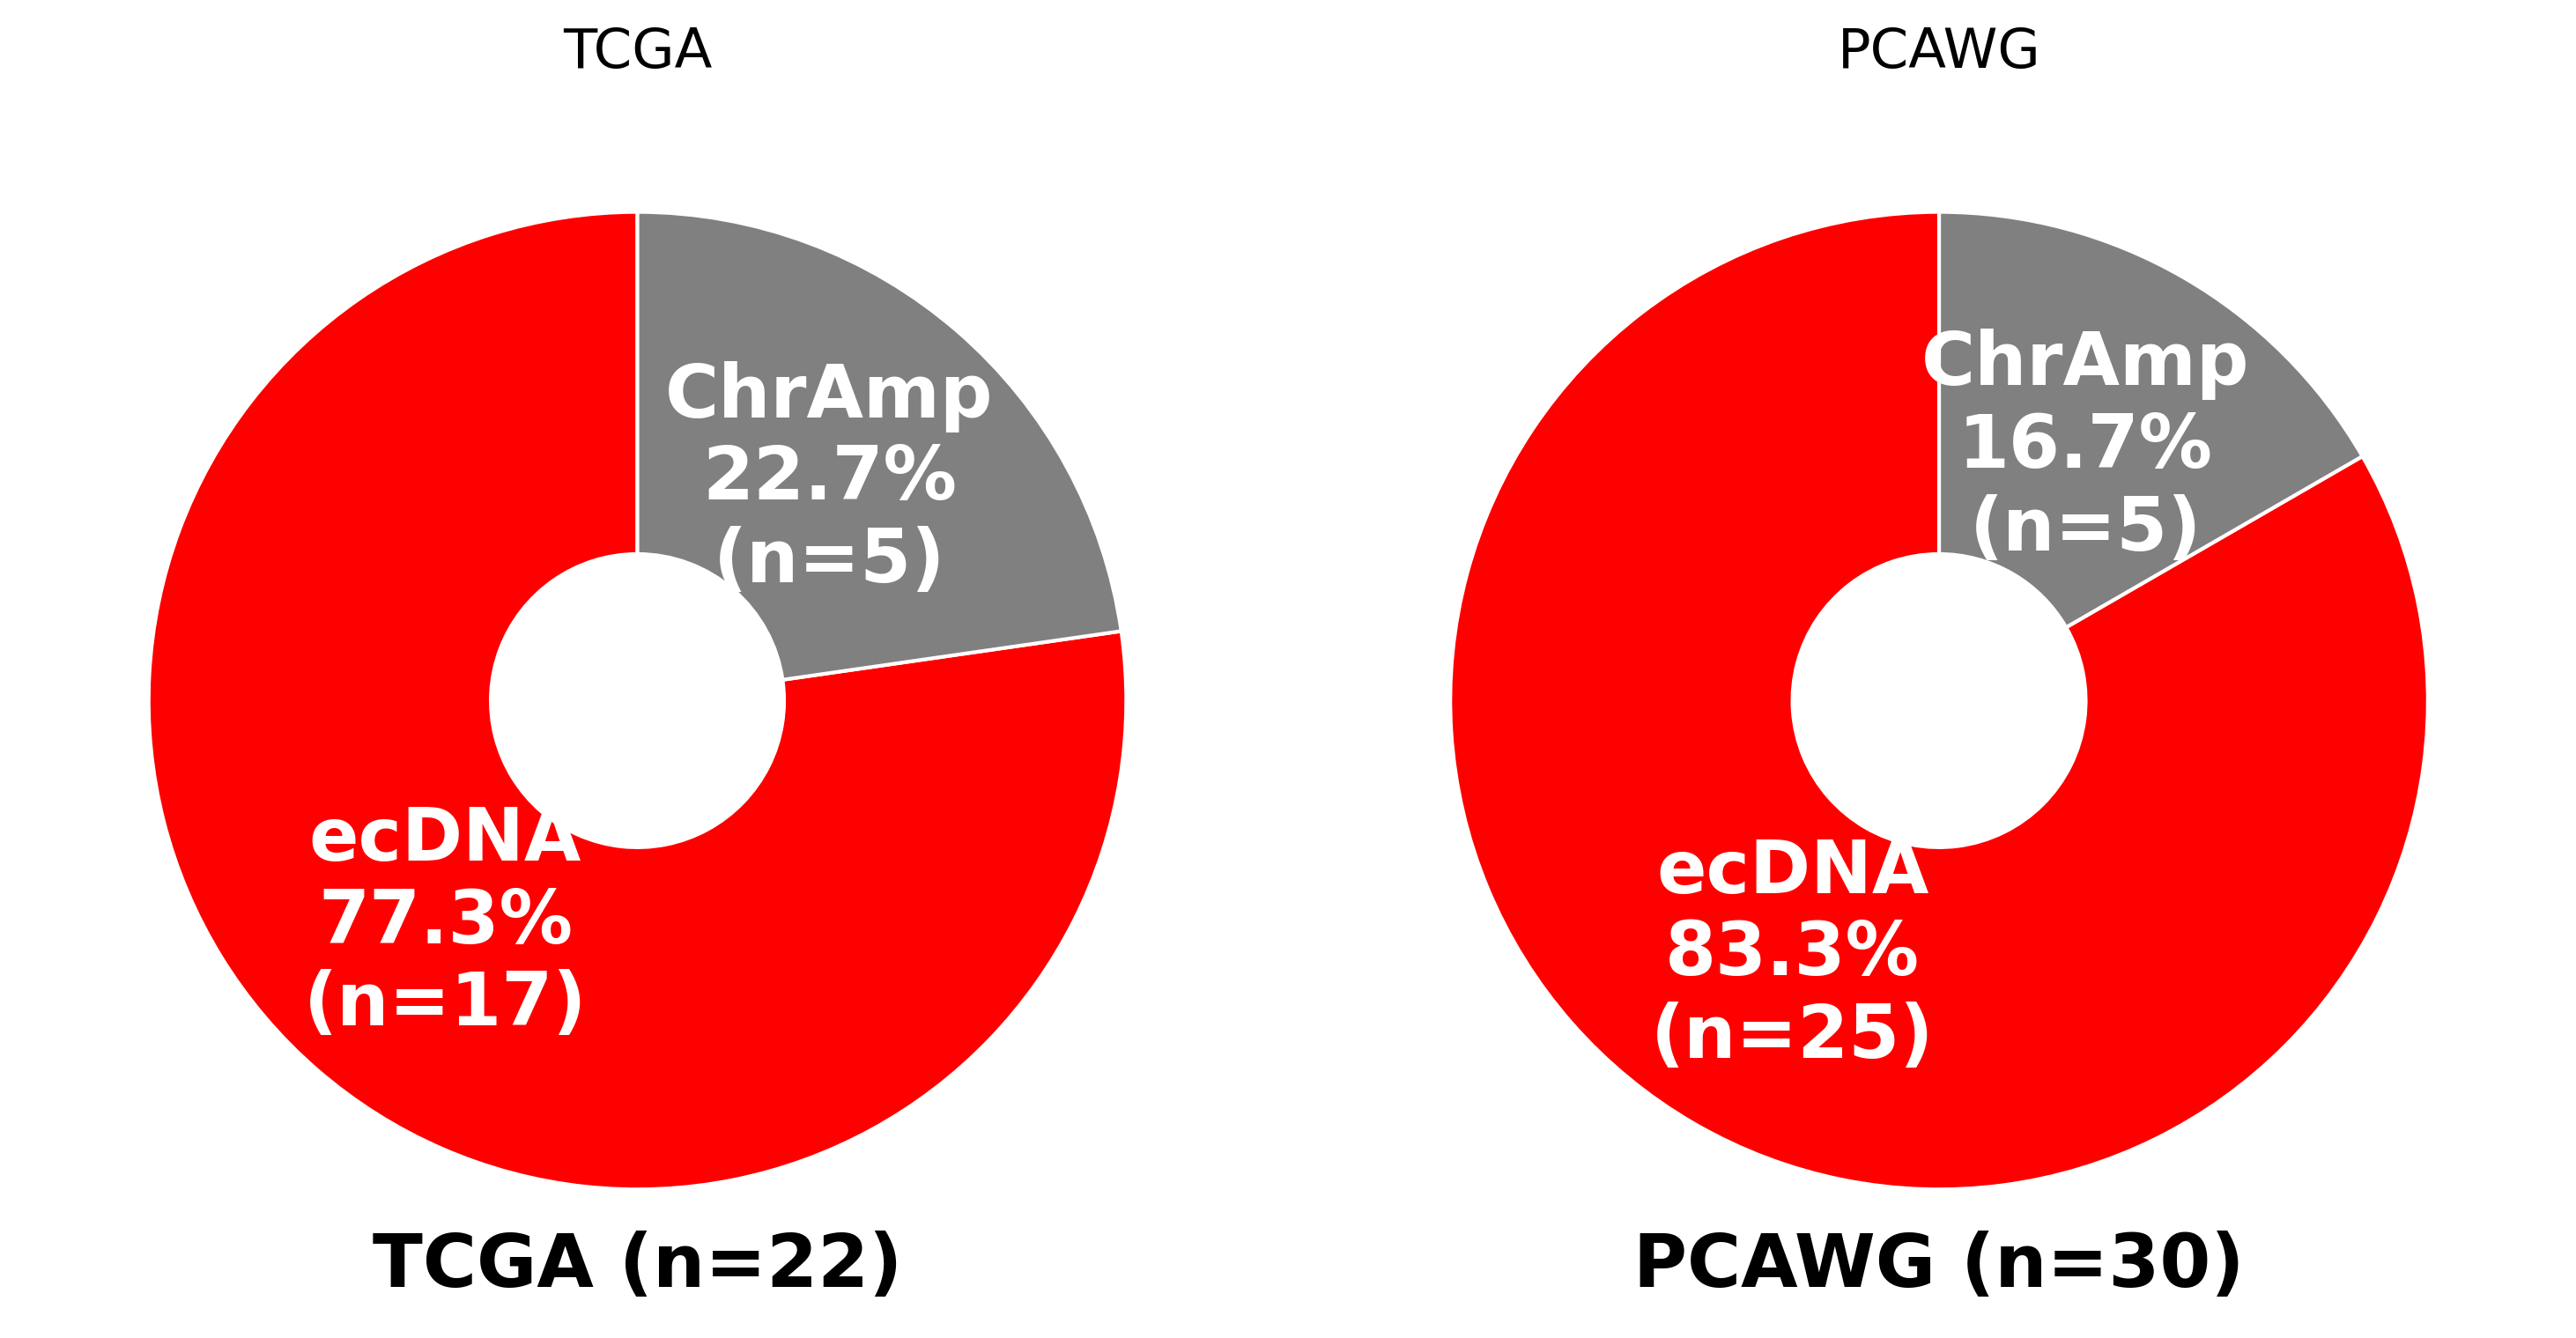

In [34]:
df = summary2.copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

colors = ['red', 'gray']
labels = ['ecDNA', 'ChrAmp']

for i, cohort in enumerate(df.index):
    sizes = [df.loc[cohort, 'ecDNA'], df.loc[cohort, 'ChrAmp']]
    total = int(df.loc[cohort, 'total_MYC+'])

    def autopct_func(pct):
        count = int(round(pct * total / 100.0))
        label = labels[0] if pct > 50 else labels[1]
        return f"{label}\n{pct:.1f}%\n(n={count})"

    wedges, texts, autotexts = axes[i].pie(
        sizes,
        colors=colors,
        startangle=90,
        autopct=autopct_func,
        textprops={'fontsize': 20, 'color': 'white','fontweight':'bold'},
        wedgeprops={'edgecolor': 'white', 'width': 0.7}
    )

    axes[i].set_title(cohort, fontsize=15)
    axes[i].text(0, -1.2, f"{cohort} (n={total})", ha='center', fontsize=20,fontweight='bold')

plt.tight_layout()
# plt.savefig("MYC_amp_by_cohort_pie_gray.png", dpi=300, bbox_inches='tight')
plt.show()
